# AB Testing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [2]:
# total number of actions
len(df)

8188

In [3]:
# number of unique users
df['id'].nunique()

6328

In [4]:
# size of experiment group unique users
df[df['group'] == 'experiment']['id'].nunique()

2996

In [5]:
# size of control group unique users
df[df['group'] == 'control']['id'].nunique()

3332

### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [6]:
# duration of this experiment
import datetime
from datetime import timedelta
datetimeFormat = '%Y-%m-%d %H:%M:%S.%f'

diff = datetime.datetime.strptime(df.timestamp.max(), datetimeFormat) - datetime.datetime.strptime(df.timestamp.min(), datetimeFormat)

print('Start:', df.timestamp.min())
print('End:', df.timestamp.max())

# df.timestamp.max().strptime(s2, FMT) - df.timestamp.min().strptime(s2, FMT)
print('\nTime difference:', diff)

Start: 2016-09-24 17:42:27.839496
End: 2017-01-18 10:24:08.629327

Time difference: 115 days, 16:41:40.789831


### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [7]:
# action types in this experiment
df['action'].value_counts()

view     6328
click    1860
Name: action, dtype: int64

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

Because all the clicks can be from one user. 

Getting the proportion of the users who click is more effective than getting the number of users who click when comparing groups of different sizes

### 5. Define the click through rate (CTR) for this experiment.

CTR = total number of clicks per user / total number of page visits per user

### 6. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.



<strong>
H0: ctr_group_experiment - ctr_group_control <= 0 <br>
H1: ctr_group_experiment - ctr_group_control > 0    
</strong>    

### 7. Compute the CTR for each group

#### a. Experiment group

In [8]:
# get the experiment group
df_experiment = df[df['group'] == 'experiment']

In [9]:
# get the experiment clicks 
total_nr_clicks = len(df_experiment[df_experiment['action'] == 'click'])
total_nr_clicks

928

In [10]:
# get the experiment visits
total_nr_visits = len(df_experiment[df_experiment['action'] == 'view'])
total_nr_visits

2996

In [11]:
# get the number of users
number_of_users = df_experiment['id'].nunique()
number_of_users

2996

In [12]:
# total number of clicks per user / total number of page visits per user

# calculation needs:
# - total_nr_clicks
# - number_of_users
# - total_nr_visits

ctr_exp = (total_nr_clicks / number_of_users) / (total_nr_visits / number_of_users)
ctr_exp

0.3097463284379172

#### b. Control group

In [13]:
# get the experiment group
df_cnt = df[df['group'] == 'control']

In [14]:
# get the total number of clicks
total_nr_clicks = len(df_cnt[df_cnt['action'] == 'click'])
total_nr_clicks

932

In [15]:
# get number of visits
total_nr_visits = len(df_cnt[df_cnt['action'] == 'view'])
total_nr_visits

3332

In [16]:
df_cnt['id'].nunique()

3332

In [17]:
# ctr = total number of clicks per user / total number of views per user

# Calculations needs: 
# - total_nr_clicks
# - number_of_users
# - total_nr_visits

ctr_cnt = (total_nr_clicks/number_of_users) / (total_nr_visits/number_of_users)
ctr_cnt

0.2797118847539016

### Observation

In [18]:
obs_diff = ctr_exp - ctr_cnt 
obs_diff

0.030034443684015644

<strong>Experiment ctr is about 3% higher than the control group</strong>
- now check is this observed difference is significant and not just due to chance. 

### What you think should happen
I need to test the hypotheses. Proof that H0 can be rejected.  In other word proof that ctr_exp - ctr_cnt <= 0 is false.

1. Bootstrap the difference in porportions

## 

In [19]:
diffs = []

for _ in range(10000):
    df_sample = df.sample(df.shape[0], replace = True)
    df_ctr = df_sample[df_sample['group'] == 'control']
    df_exp = df_sample[df_sample['group'] == 'experiment']

    # ctr = total number of clicks per user / total number of views per user
    # calculations needs: 
    # - total_nr_clicks
    # - total_nr_visits
    # - number_of_users

    # control group
    # calculate ctr
    total_nr_clicks = len(df_ctr[df_ctr['action'] == 'click'])
    total_nr_visits = len(df_ctr[df_ctr['action'] == 'view'])
    number_of_users = df_ctr['id'].nunique()
    ctr_ctr = (total_nr_clicks / number_of_users) / (total_nr_visits / number_of_users)

    # experiment group
    # calculate ctr
    total_nr_clicks = len(df_exp[df_exp['action'] == 'click'])
    total_nr_visits = len(df_exp[df_exp['action'] == 'view'])
    number_of_users = df_exp['id'].nunique()
    ctr_exp = (total_nr_clicks / number_of_users) / (total_nr_visits / number_of_users)

    # calculate difference
    ctr_diff = ctr_exp - ctr_ctr

    diffs.append(ctr_diff)

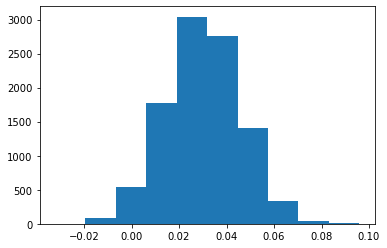

In [20]:
plt.hist(diffs);

### Now simulate from the H0
now that we have done the bootstrap for the differences in ctr, simulate the H0. 
Do this by taking the bootstrapped differences standard deviation and create a random normal list with that standard deviation that is centered around 0 and with a size the same as the bootstrap size. This creates a normal distibution.

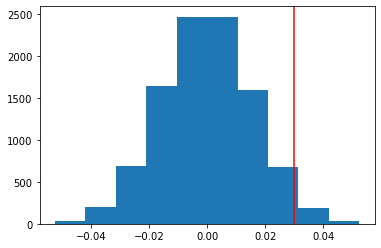

In [21]:
np_diffs = np.array(diffs)
null_vals = np.random.normal(0, np_diffs.std(), np_diffs.size)
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');

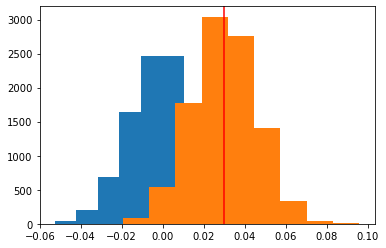

In [22]:
# over lap the t2wo
plt.hist(null_vals);
plt.hist(diffs);
plt.axvline(x=obs_diff, color='red');

### Calculate the P value

In [23]:
p_value = (null_vals > obs_diff).mean()
p_value

0.0272

In [24]:
if p_value < 0.05:
    print('reject H0')
else:
    print('fail to reject H0')

reject H0


### Let's recap the steps we took to analyze the results of this A/B test.

1. We computed the observed difference between the metric, click through rate, for the control and experiment group. <br>
2. We simulated the sampling distribution for the difference in proportions (or difference in click through rates). <br>
3. We used this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size. <br>
4. We computed the p-value by finding the proportion of values in the null distribution that were greater than our observed difference. <br>
5. We used this p-value to determine the statistical significance of our observed difference.<br>